In [1]:
###################掛載雲端硬碟上#############
from google.colab import drive
drive.mount('/content/drive')
##############################################

Mounted at /content/drive


In [2]:
#導入資料
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
dict_labels = {
        'Butterfly':0,
        'Dragonfly':1,
        'Grasshopper':2,
        'Ladybird':3,
        'Mosquito':4
        }
size = (64,64)
nbofdata = 1000 #每個資料結抓取的特定count
images=[]
labels_hot=[]
labels=[]

#rotation=[0,30,60,90,120,150,180,210,240,270,300,330]

for folders in glob.glob("/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_data/*"): #抓取子資料夾
  print(folders)
  nbofdata_i=1
  for filename in os.listdir(folders): #抓取子資料夾所有檔案
    if nbofdata_i <= nbofdata: #限制抓取幾個檔案
      label = os.path.basename(folders) #取出檔案名字
      className = np.asarray(label) #跟array一樣 但asarray是cut過去 如果原有產生的值改變 asarray sending的variable也會跟著改變value 比較不會占用memory
      img = cv2.imread(os.path.join(folders,filename))
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img = cv2.resize(img,size)
      if img is not None:
        if label is not None:
          labels.append(className) #name
          labels_hot.append(dict_labels[label])
          images.append(img)
          nbofdata_i += 1

img = np.array(images)
labels_hot = np.array(labels_hot)

np.save('/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_img.npy',img)
np.save('/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_labels.npy',labels_hot)

print(img.shape)
print(labels_hot.shape)

/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_data/Grasshopper
/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_data/Ladybird
/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_data/Dragonfly
/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_data/Mosquito
/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_data/Butterfly
(4413, 64, 64, 3)
(4413,)


In [3]:
import numpy as np
img = np.load('/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_img.npy')
labels_hot = np.load('/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Insect_labels.npy')
print(img.shape)

(4413, 64, 64, 3)


Epoch 1/80
220/220 [==============================] - 15s 29ms/step - loss: 1.7217 - accuracy: 0.3497 - val_loss: 1.7308 - val_accuracy: 0.3307 - lr: 0.0300
Epoch 2/80
220/220 [==============================] - 8s 37ms/step - loss: 1.3606 - accuracy: 0.4195 - val_loss: 1.4165 - val_accuracy: 0.3851 - lr: 0.0300
Epoch 3/80
220/220 [==============================] - 6s 25ms/step - loss: 1.2908 - accuracy: 0.4636 - val_loss: 1.8349 - val_accuracy: 0.3771 - lr: 0.0300
Epoch 4/80
220/220 [==============================] - 5s 25ms/step - loss: 1.2458 - accuracy: 0.5037 - val_loss: 1.5944 - val_accuracy: 0.3998 - lr: 0.0300
Epoch 5/80
220/220 [==============================] - 6s 27ms/step - loss: 1.2115 - accuracy: 0.5017 - val_loss: 1.6677 - val_accuracy: 0.3307 - lr: 0.0300
Epoch 6/80
220/220 [==============================] - 5s 24ms/step - loss: 1.1156 - accuracy: 0.5492 - val_loss: 1.2999 - val_accuracy: 0.5130 - lr: 0.0150
Epoch 7/80
220/220 [==============================] - 8s 36ms/s

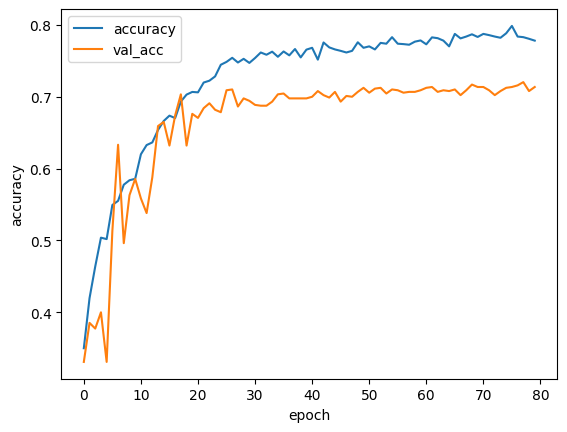

Test accuracy score: 0.7134767770767212
Test loss score: 0.8578351736068726


In [4]:
#數據訓練
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten,BatchNormalization,Dropout,Dense,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

#random sort datas
index = [i for i in range(len(labels_hot))]
np.random.shuffle(index)
img = img[index]
labels_hot = labels_hot[index]

train_data,test_data,train_label,test_label = train_test_split(img,labels_hot,test_size=0.2) #,random_state 也能在這邊設datas sort

train_datagen=ImageDataGenerator(
        rotation_range=40, #隨機轉角度
        width_shift_range=0.1, #水平平移
        height_shift_range=0.1, #上下平移
       )
'''
        horizontal_flip=True, #水平翻轉
        width_shift_range=0.1,
        height_shift_range=0.1
'''
train_datagen.fit(train_data)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=0.0001)

train_data = np.reshape(train_data,(-1,64,64,3)) #-1 代表全部
test_data = np.reshape(test_data,(-1,64,64,3))

train_label = to_categorical(train_label) #one_hot
test_label = to_categorical(test_label)

model = Sequential()
#,activation='relu'
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(2,2),strides=(1,1),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(2,2),strides=(1,1),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(2,2),strides=(1,1),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

adam = optimizers.Adam(learning_rate=0.03)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
#history = model.fit(train_data,train_label,batch_size=32,epochs=100,validation_data=(test_data,test_label))
history = model.fit(train_datagen.flow(train_data,train_label,batch_size=16),steps_per_epoch=len(train_data)//16,epochs=80,validation_data=(test_data,test_label),callbacks=[reduce_lr])#steps_per_epoch指定生成批量數
score = model.evaluate(test_data,test_label,verbose=1)

plt.plot(history.history["accuracy"],label='accuracy')
plt.plot(history.history["val_accuracy"],label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print('Test accuracy score:',score[1])
print('Test loss score:',score[0])

In [5]:
#儲存模型
import tensorflow as tf
model_path = '/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/model'
tf.keras.models.save_model(model, model_path)

In [8]:
#數據預測
import tensorflow as tf
from PIL import Image
import numpy as np

# 載入圖片
image = Image.open('/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/Butterfly_0.jpg')

# 指定已保存模型的路徑
model_path = '/content/drive/MyDrive/AI專案/昆蟲識別_AI專案/model'

# 假設模型期望的輸入形狀為 (width, height)，進行調整大小
image = image.resize((64, 64))


# 將圖片轉換為 numpy 陣列
image = np.array(image)
print(image.shape)

# 將圖片轉換為模型所需的批次形狀，例如 (1, width, height, channels)
input_data = np.expand_dims(image, axis=0)

# 載入模型
model = tf.keras.models.load_model(model_path)

# 使用載入的模型進行預測
predictions = model.predict(input_data)

# 處理預測結果
predicted_label = np.argmax(predictions)

print('預測結果:', predicted_label)

(64, 64, 3)
1/1 [==============================] - 0s 411ms/step
預測結果: 0
